In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)

2.9.1+cu126


In [3]:
from nik_io import load_event
from nik_model import NIK_SIREN_REIM
from nik_train import prepare_tensors, fit_one_frame_slice_coil, plot_measured_vs_pred_kspace, overfit_fixed_subset
from nik_recon import ifft1d_kz_to_z
import numpy as np
from nik_recon import nufft2d_recon

In [4]:

# Load data with images
event = load_event("XCAT-ERIC/results/simulation_results_20260115T150400.mat", load_images=True)
k_np, traj_np = event["k"], event["traj"]
gt_img = event.get("gt_img")  # Ground truth images
rc_img = event.get("rc_img")  # Reconstructed images from file

# Set in expected dimension order
k_np = np.transpose(k_np, (0, 2, 1, 3))
traj_np = np.transpose(traj_np, (0, 2, 1, 3))

T, S, C, RO = k_np.shape
print("k DCE shape : ", k_np.shape)
print("trajectory shape : ", traj_np.shape)

k_t, traj_t, scales, dims, k_scale = prepare_tensors(k_np, traj_np, data_device="cuda")

# Select parameters
t_frame = 0  # Which time frame to reconstruct
coil_idx = 0  # Which coil to use
n_steps = 3000  # Training steps per slice
batch_size = 65536
lr = 1e-4

# iFFT kz -> z (interleaved spokes -> z slices)
k_img_space, n_z_slices, n_ro_per_slice, kz_sort_order = ifft1d_kz_to_z(k_t, traj_t, t_frame=t_frame)
print(f"Number of z slices: {n_z_slices}")
print(f"Readouts per slice: {n_ro_per_slice}")

z_slice_idx = n_z_slices // 2  # Middle z-slice


def make_fixed_frame_zslice_coil_dataset(
    k_img_space,
    traj_t,
    scales,
    dims,
    *,
    y_scale,
    t_fixed: int = 0,
    coil_fixed: int = 0,
    z_slice_idx: int = 0,
    n_slices: int = None,
    compute_device: str = "cuda",
):
    """
    Build a deterministic dataset for ONE frame, ONE z-slice, ONE coil
    after kz->z IFFT.

    returns:
      x_all   : (N,4) float  [kx, ky, z_norm, t_norm]
      y_all   : (N,2) float  [Re, Im]
      kx_all, ky_all : (N,) float (for plotting)
    """
    sx, sy, _ = scales
    T, S, C, RO = dims
    dev_data = k_img_space.device
    dev_compute = torch.device(compute_device)

    assert 0 <= t_fixed < T
    assert 0 <= coil_fixed < C

    if n_slices is None:
        kz_vals = traj_t[t_fixed, :, 2, 0]
        n_slices = len(torch.unique(kz_vals))

    z_slice_idx = int(max(0, min(int(z_slice_idx), int(n_slices - 1))))

    # Interleaved readouts for one slice
    indices = torch.arange(0, S, n_slices, device=traj_t.device)

    # kx, ky for those readouts
    kx = traj_t[t_fixed, indices, 0, :] / sx
    ky = traj_t[t_fixed, indices, 1, :] / sy

    # Fixed z and t (normalized to [-1, 1])
    z_norm = (torch.tensor(z_slice_idx, device=dev_data, dtype=traj_t.dtype) / (n_slices - 1 + 1e-8)) * 2.0 - 1.0
    t_norm = (torch.tensor(t_fixed, device=dev_data, dtype=traj_t.dtype) / (T - 1 + 1e-8)) * 2.0 - 1.0
    z_col = torch.full((indices.numel(), RO), z_norm, device=dev_data, dtype=traj_t.dtype)
    t_col = torch.full((indices.numel(), RO), t_norm, device=dev_data, dtype=traj_t.dtype)

    # Flatten to (N,)
    kx_all = kx.reshape(-1)
    ky_all = ky.reshape(-1)
    z_all = z_col.reshape(-1)
    t_all = t_col.reshape(-1)

    x_all = torch.stack([kx_all, ky_all, z_all, t_all], dim=1).float()

    # Measured k-space for this coil/slice: (n_ro_per_slice, RO) -> (N,)
    y = k_img_space[t_fixed, :, coil_fixed, z_slice_idx, :].reshape(-1)
    y_ri = torch.view_as_real(y).float()

    non_block = (dev_data.type == "cuda" and dev_compute.type == "cuda")
    x_all = x_all.to(dev_compute, non_blocking=non_block)
    y_ri = y_ri.to(dev_compute, non_blocking=non_block)
    kx_all = kx_all.to(dev_compute, non_blocking=non_block)
    ky_all = ky_all.to(dev_compute, non_blocking=non_block)

    y_ri = y_ri / y_scale

    meta = {
        "t_fixed": t_fixed,
        "coil_fixed": coil_fixed,
        "z_slice_idx": z_slice_idx,
        "n_slices": int(n_slices),
        "n_ro_per_slice": int(indices.numel()),
        "N": int(x_all.shape[0]),
        "y_scale": float(y_scale.item()) if isinstance(y_scale, torch.Tensor) else float(y_scale),
    }
    return x_all, y_ri, kx_all, ky_all, meta


x_all, y_all, kx_all, ky_all, meta = make_fixed_frame_zslice_coil_dataset(
    k_img_space,
    traj_t,
    scales,
    dims,
    y_scale=k_scale,
    t_fixed=t_frame,
    coil_fixed=coil_idx,
    z_slice_idx=z_slice_idx,
    n_slices=n_z_slices,
    compute_device="cuda",
)
print(meta)

# Automatically get image size from loaded data
if gt_img is not None:
    print(gt_img.shape)
    img_size = gt_img.shape[2:4]
elif rc_img is not None:
    print(rc_img.shape)
    img_size = rc_img.shape[2:4]
else:
    img_size = (128, 128)  # fallback
print(f"Using image size: {img_size}")


model = NIK_SIREN_REIM(n_coils=1)  # number of coils from k.shape


pred_imgs = []
pred_steps = []

def cb(step, model):
    with torch.no_grad():
        model.eval()

        coil_idx_all = torch.full((x_all.shape[0],), int(coil_idx), device=x_all.device, dtype=torch.long)
        y_pred_all = model(x_all, coil_idx_all) * k_scale
        k_pred = torch.complex(y_pred_all[:, 0], y_pred_all[:, 1]).reshape(n_ro_per_slice, RO)

        k_img_space_pred = torch.zeros_like(k_img_space)
        k_img_space_pred[t_frame, :, coil_idx, z_slice_idx, :] = k_pred

        img_pred = nufft2d_recon(
            k_img_space_pred, traj_t,
            t_frame=t_frame, coil_idx=coil_idx, z_slice_idx=z_slice_idx,
            scales=scales, img_size=img_size, n_slices=n_z_slices
        )

        pred_imgs.append(img_pred)
        pred_steps.append(step)

        model.train()

model, info = fit_one_frame_slice_coil(
    model,
    x_all=x_all, y_all=y_all,
    coil_fixed=meta["coil_fixed"],
    steps=n_steps,
    batch_size=batch_size,
    lr=lr,
    amp=False,
    device="cuda",
    use_tqdm=True,
    callback=cb,
    callback_every=250,  # plot every 250 steps
)



k DCE shape :  (60, 392, 8, 220)
trajectory shape :  (60, 392, 3, 220)
Number of z slices: 7
Readouts per slice: 56
{'t_fixed': 0, 'coil_fixed': 0, 'z_slice_idx': 3, 'n_slices': 7, 'n_ro_per_slice': 56, 'N': 12320, 'y_scale': 42.0473518371582}
(121, 7, 220, 152)
Using image size: (220, 152)


/scratch/rnga/vvpshenov/micromamba/envs/torch29/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Overfitting fixed (t,kz,coil): 100%|█| 3000/3000 [02:27<00:00, 20.37it/s, mse=7.


In [5]:
t = t_frame
G = n_z_slices
S = traj_t.shape[1]

idx0 = torch.arange(0, S, G, device=traj_t.device)
idx1 = torch.arange(1, S, G, device=traj_t.device)

dkx = (traj_t[t, idx0, 0, :] - traj_t[t, idx1, 0, :]).abs().max().item()
dky = (traj_t[t, idx0, 1, :] - traj_t[t, idx1, 1, :]).abs().max().item()
print("max |Δkx|:", dkx, "max |Δky|:", dky)

max |Δkx|: 0.0 max |Δky|: 0.0


/home/rnga/vvpshenov/tmp/ipykernel_1435925/1089782763.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


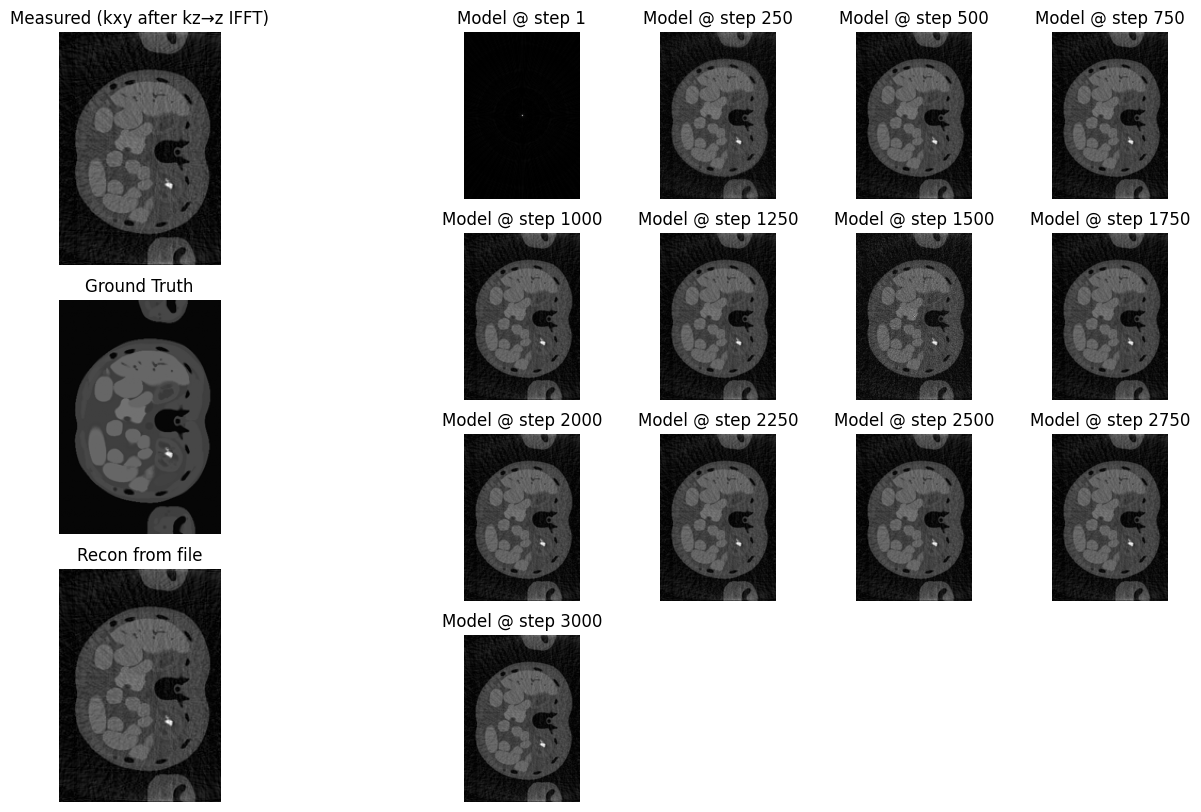

In [6]:
import math
import matplotlib.pyplot as plt

# --- left panel: fixed reference images ---
img_measured = nufft2d_recon(
    k_img_space, traj_t,
    t_frame=t_frame, coil_idx=coil_idx, z_slice_idx=z_slice_idx,
    scales=scales, img_size=img_size, n_slices=n_z_slices
)

img_gt_file = gt_img[t_frame, z_slice_idx, :, :] if gt_img is not None else None
img_recon_file = rc_img[t_frame, z_slice_idx, :, :] if rc_img is not None else None

n_preds = len(pred_imgs)
cols = min(4, n_preds) if n_preds > 0 else 1
rows = math.ceil(n_preds / cols) if n_preds > 0 else 1

fig = plt.figure(figsize=(16, max(6, 2.5 * rows)))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2], wspace=0.2)

# Left: 3 stacked refs
gs_left = gs[0, 0].subgridspec(3, 1, hspace=0.15)
ax0 = fig.add_subplot(gs_left[0, 0])
ax0.imshow(img_measured, cmap="gray"); ax0.set_title("Measured (kxy after kz→z IFFT)"); ax0.axis("off")

ax1 = fig.add_subplot(gs_left[1, 0])
if img_gt_file is not None:
    ax1.imshow(img_gt_file, cmap="gray"); ax1.set_title("Ground Truth"); ax1.axis("off")
else:
    ax1.text(0.5, 0.5, "GT not available", ha="center", va="center"); ax1.axis("off")

ax2 = fig.add_subplot(gs_left[2, 0])
if img_recon_file is not None:
    ax2.imshow(img_recon_file, cmap="gray"); ax2.set_title("Recon from file"); ax2.axis("off")
else:
    ax2.text(0.5, 0.5, "Recon not available", ha="center", va="center"); ax2.axis("off")

# Right: prediction grid
gs_right = gs[0, 1].subgridspec(rows, cols, hspace=0.2, wspace=0.2)
for i in range(rows * cols):
    ax = fig.add_subplot(gs_right[i // cols, i % cols])
    if i < n_preds:
        ax.imshow(pred_imgs[i], cmap="gray")
        ax.set_title(f"Model @ step {pred_steps[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()



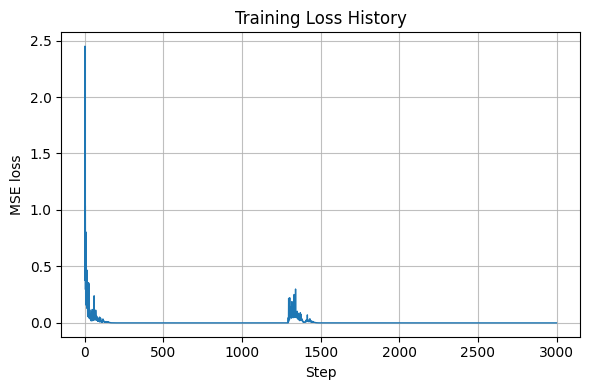

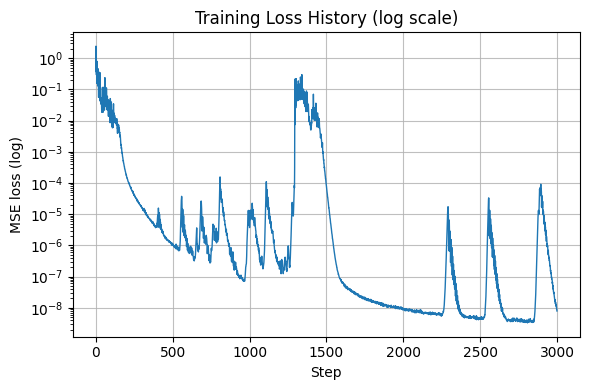

In [8]:
loss_hist = info["loss_hist"]

plt.figure(figsize=(6, 4))
plt.plot(loss_hist, lw=1)
plt.xlabel("Step")
plt.ylabel("MSE loss")
plt.title("Training Loss History")
plt.grid(True, alpha=0.8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.semilogy(loss_hist, lw=1)
plt.xlabel("Step")
plt.ylabel("MSE loss (log)")
plt.title("Training Loss History (log scale)")
plt.grid(True, alpha=0.8)
plt.tight_layout()
plt.show()